In [ ]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
ERROR: Operation cancelled by user


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
human_dna = pd.read_table('/content/human.txt')
print(human_dna.head())
print('total number of sequence data', len(human_dna.sequence))
print('sequence data sample:', human_dna.sequence[0])

                                            sequence  class
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3
total number of sequence data 4380
sequence data sample: ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG


In [ ]:
def get_kmer_count_from_sequence(sequence, k=3, cyclic=True):
    """
    Returns dictionary with keys representing all possible kmers in a sequence
    and values counting their occurrence in the sequence.
    """
    # dict to store kmers
    kmers = {}


    # count how many times each occurred in this sequence (treated as cyclic)
    for i in range(0, len(sequence)):
        kmer = sequence[i:i + k]

        # for cyclic sequence get kmers that wrap from end to beginning
        length = len(kmer)
        if cyclic:
            if len(kmer) != k:
                kmer += sequence[:(k - length)]

        # if not cyclic then skip kmers at end of sequence
        else:
            if len(kmer) != k:
                continue

        # count occurrence of this kmer in sequence
        if kmer in kmers:
            kmers[kmer] += 1
        else:
            kmers[kmer] = 1

    return kmers

def get_debruijn_edges_from_kmers(kmers):
    """
    Every possible (k-1)mer (n-1 suffix and prefix of kmers) is assigned
    to a node, and we connect one node to another if the (k-1)mer overlaps
    another. Nodes are (k-1)mers, edges are kmers.
    """
    # store edges as tuples in a set
    edges = set()

    # compare each (k-1)mer
    for k1 in kmers:
        for k2 in kmers:
            if k1 != k2:
                # if they overlap then add to edges
                if k1[1:] == k2[:-1]:
                    edges.add((k1[:-1], k2[:-1]))
                if k1[:-1] == k2[1:]:
                    edges.add((k2[:-1], k1[:-1]))

    return edges

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph_list_k3 = []
count = 0
for seq in human_dna.sequence[:400]:
  count = count + 1
  kmers = get_kmer_count_from_sequence(seq, k=3) #setting k = 3
  edges = get_debruijn_edges_from_kmers(kmers)
  graph = nx.DiGraph()
  graph.add_edges_from(edges)
  graph_list_k3.append(graph)
  print('graph complemeted', count)


In [ ]:
from node2vec import Node2Vec
print('total number of graphs', len(graph_list_k3))
count = 1
embedding_model_list_k3 = []
for g in graph_list_k3:
  node2vec = Node2Vec(g, dimensions=64, walk_length=30, num_walks=200, workers=4)
  model = node2vec.fit(window=10, min_count=1, batch_words=4)
  embeddings = {node: model.wv[node] for node in g.nodes()}
  embedding_model_list_k3.append(embeddings)
  print('embeddings', count)
  count = count+1


In [ ]:
#converting to list of input vectors
input_vector_list_k3 = []
for e in embedding_model_list_k3:
  input_vector = [0] * 64
  for node in e:
    for i in range(0,64):
      input_vector[i] = input_vector[i] + e[node][i]
  input_vector_list_k3.append(input_vector)

print('total number of input vectors:', len(input_vector_list_k3))
print('input vector example:')
print(input_vector_list_k3[0])


total number of input vectors: 1000
input vector example:
[-1.063913483172655, -0.6143858283758163, 3.589293621480465, 0.6274942271411419, -0.8616227377206087, -3.317371167242527, 1.1785883447155356, 0.23242050036787987, -1.0239350507035851, -1.8238929342478514, 3.2738034054636955, 1.309331113792723, -0.6310365507379174, -0.7932124584913254, -2.0570351369678974, -1.144334726035595, -0.5878555374220014, 1.2707488196901977, 1.4775301204062998, 0.8560665948316455, 1.5699244476854801, 0.7508510191401001, 3.0126952677965164, -0.9168094181804918, 0.648288875236176, 2.5077166743576527, -1.7544316807761788, 1.4066630396991968, 0.14111835160292685, -1.4456960051320493, -0.2046915702521801, -0.33259192551486194, -3.0772901624441147, -1.5676613440737128, 0.08525089034810662, 1.5096106545533985, 1.3470040336251259, 1.4963989533134736, 3.7045228332281113, -0.742545323446393, 2.170031176880002, 1.8594572246074677, -1.5340868745697662, -3.8071575313806534, 2.105048870667815, -1.2671421936247498, -0.7

In [ ]:
#to store in csv file
import csv
file_name = 'vector_list_k3.csv'
column = []
for i in range(1,65):
  column.append('x'+str(i))
with open(file_name, 'w', newline = '' )as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(column)
    csv_writer.writerows(input_vector_list_k3)

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pandas as pd

df = pd.read_csv('vector_list_k3.csv',header=0)

human_dna.rename(columns={'class': 'label'}, inplace=True)
y = human_dna.label

X =df
y = y[:1000]

 # Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64
0,-1.063913,-0.614386,3.589294,0.627494,-0.861623,-3.317371,1.178588,0.232421,-1.023935,-1.823893,...,3.525942,-1.264949,0.625417,-2.229896,0.016374,-0.511048,1.055709,-2.289867,-1.177463,0.543910
1,-1.132925,-1.098834,4.195835,1.250501,-1.171664,-2.994081,0.723127,-0.358603,-0.442710,-1.622845,...,2.763854,-0.243997,0.316953,-0.985771,-1.534397,0.380518,0.733974,-2.128851,-0.058133,0.971311
2,-0.700736,-0.257119,3.851990,1.640641,-0.619082,-3.631052,-0.254813,-1.022559,-2.078818,-3.452326,...,2.541278,-0.651813,-0.173200,-2.216043,0.060968,-0.205914,0.485222,-2.923363,-0.600121,0.274659
3,-1.132701,-0.566543,3.758166,0.897194,-1.433792,-4.125736,-0.439815,0.088628,-1.827040,-2.621323,...,3.254375,0.021767,0.039201,-2.074748,-0.572100,0.230382,0.691702,-2.726322,-0.469460,0.153491
4,-0.910642,-0.062343,3.935728,1.093689,-0.671074,-4.008127,0.031051,-0.291061,-1.142952,-1.818726,...,3.216843,-0.433316,0.290355,-1.979855,-0.152407,-0.771367,0.585773,-3.236853,-0.828120,0.121985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.634420,-0.902326,3.837259,0.575909,-1.018076,-3.360424,-0.989536,-0.141581,-1.684590,-2.524305,...,2.713808,-0.232927,0.511934,-2.384730,-0.885990,0.798572,1.096087,-2.758908,-0.504794,0.624385
996,-0.470065,-1.156756,4.256799,-0.088680,-0.836200,-2.632594,-0.513286,-1.304525,-1.488770,-1.756488,...,2.846254,0.539482,1.269385,-2.246999,-0.302008,0.495281,1.247758,-2.481123,-0.557662,1.864882
997,-0.798566,-1.419251,3.397020,0.230324,-0.512752,-3.351242,-1.472655,-0.294512,-1.059929,-1.905321,...,2.203214,-0.529317,-0.126225,-2.321114,-0.217412,-0.316947,1.080516,-2.671828,-0.746953,0.927594
998,-0.600567,-1.177201,3.750324,1.319977,-1.505089,-3.066850,0.860823,1.160312,-1.787290,-2.151259,...,2.866630,-0.293327,0.638703,-2.006607,0.023213,0.052511,1.344749,-2.059885,-1.095699,1.242755



 Confusion Matrix:

[[ 0  0  0  0  0  0 28]
 [ 0  0  0  0  0  0 33]
 [ 0  0  0  0  0  0 14]
 [ 0  0  0  0  0  0 33]
 [ 0  0  0  0  0  0 29]
 [ 0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0 54]]




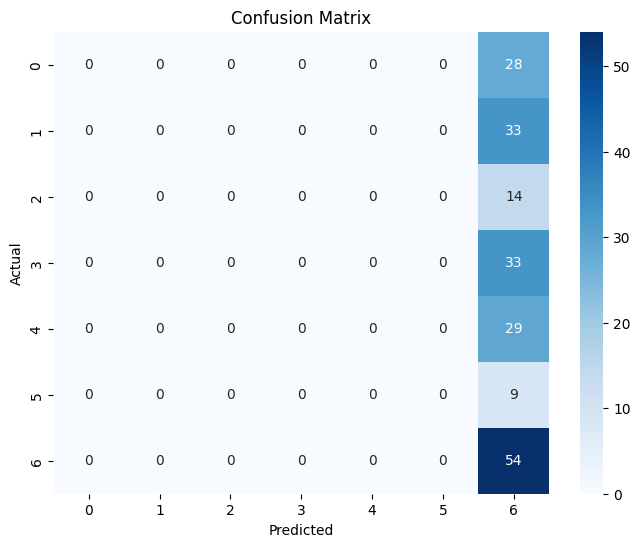

Accuracy: 27.00%


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Create and train the Support Vector Machine (SVM) classifier with RBF kernel
classifier = svm.SVC(decision_function_shape='ovo')
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

# Display confusion matrix for the classification prediction on training data
conf_matrix = confusion_matrix(y_test, prediction)
print("\n Confusion Matrix:\n")
print(conf_matrix)

# Plot Confusion Matrix
print("\n")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy = accuracy_score(y_test, prediction)
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")